In [1]:
import os, time, sys
import numpy as np
# np.random.bit_generator = np.random._bit_generator
import torch
from torchvision import transforms, datasets
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import seaborn as sb
# import imgaug
# from AdaBound import adabound
device = "cuda"

# Efficient net

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_pretrained('efficientnet-b3')

out_channels = 1280  #eff-b0
# out_channels = 1536  #eff-b3


class EffNet(nn.Module):
    def __init__(self,in_channels=3):
        super().__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b0',in_channels=in_channels)
        self._avg_pooling = nn.AdaptiveAvgPool2d(1)
        self._dropout = nn.Dropout(0.2)
        self._fc_root = nn.Linear(out_channels, 168)
        self._fc_vowel = nn.Linear(out_channels, 11)
        self._fc_constant = nn.Linear(out_channels, 7)
        
    def forward(self, inputs):
        bs = inputs.size(0)
        # Convolution layers
        x = self.backbone.extract_features(inputs)
#         print("feature size:", x.size())
        
        # Pooling and final linear layer
        x = self._avg_pooling(x)
        x = x.view(bs, -1)
        x = self._dropout(x)

        out_root = self._fc_root(x)
        out_vowel = self._fc_vowel(x)
        out_constant = self._fc_constant(x)
        
        return out_root, out_vowel, out_constant
        
        

# SE_Res_NET

In [3]:
from se_resnet import *
from collections import OrderedDict

def get_resnext_model(model_type="101", pretrained=True):
    if model_type == "101":
        model = se_resnext101_32x4d(num_classes=1000, pretrained=pretrained)
    elif model_type== "50":
        model = se_resnext50_32x4d(num_classes=1000, pretrained=pretrained)
    else:
        print("!!!Wrong se_res model structure!!!")
        return
    inplanes = 64  ###inplanes above!!!
    input_channels = 1
    layer0_modules = [
        ('conv1', nn.Conv2d(input_channels, inplanes, kernel_size=7, stride=2,    
                            padding=3, bias=False)),
        ('bn1', nn.BatchNorm2d(inplanes)),
        ('relu1', nn.ReLU(inplace=True)),
    ]        
    layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,ceil_mode=True)))
    model.layer0 = nn.Sequential(OrderedDict(layer0_modules))
    model.classifier_root = nn.Linear(model.feature_dim, 168)
    model.classifier_vowel = nn.Linear(model.feature_dim, 11)
    model.classifier_constant = nn.Linear(model.feature_dim, 7)
    return model




# Dice loss & Focal loss

In [4]:
import torch.nn.functional as F

# def dice_loss(input, target):
#     input = torch.sigmoid(input)
#     smooth = 1.

#     iflat = input.view(-1)
#     tflat = target.view(-1)
    
#     print(iflat.shape(),tflat.shape())
    
#     intersection = (iflat * tflat).sum()
    
#     return 1 - ((2. * intersection + smooth) /
#               (iflat.sum() + tflat.sum() + smooth))


def dice_loss(input, target):
    smooth = 1.
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

def one_hot(index, classes):
    size = index.size() + (classes,)
    view = index.size() + (1,)

    mask = torch.Tensor(*size).fill_(0)
    index = index.view(*view)
    ones = 1.

    return mask.scatter_(1, index, ones)


# https://github.com/DingKe/pytorch_workplace/blob/master/focalloss/loss.py
class FocalLossWithOneHot(nn.Module):
    def __init__(self, gamma=2, eps=1e-7):
        super(FocalLossWithOneHot, self).__init__()
        self.gamma = gamma
        self.eps = eps

    def forward(self, input, target):
        y = one_hot(target, input.size(-1))

        logit = F.softmax(input, dim=-1)
        logit = logit.clamp(self.eps, 1. - self.eps)

        loss = -1 * y * torch.log(logit) # cross entropy
        loss = loss * (1 - logit) ** self.gamma # focal loss

        return loss.sum()
#         return loss.mean()


class FocalLossWithOutOneHot(nn.Module):
    def __init__(self, gamma=2, eps=1e-7):
        super(FocalLossWithOutOneHot, self).__init__()
        self.gamma = gamma
        self.eps = eps

    def forward(self, input, target):
        logit = F.softmax(input, dim=1)
        logit = logit.clamp(self.eps, 1. - self.eps)
        logit_ls = torch.log(logit)
        loss = F.nll_loss(logit_ls, target, reduction="none")
        view = target.size() + (1,)
        index = target.view(*view)
        loss = loss * (1 - logit.gather(1, index).squeeze(1)) ** self.gamma # focal loss

        return loss.sum()

# Test model output

In [5]:
# # model = SE_Net3(in_channels=1)
# # model = EffNet(in_channels=1)
# # model = se_resnext()
# # model = se_resnext101_32x4d(num_classes=1000, pretrained=True)
# model = get_resnext_model(model_type="50")
# model.cuda()
# print(model)


# # # summary(model, input_size=(3, 28, 28))
# tensor_in = torch.zeros(size=(2,1,224,224),dtype=torch.float32).to("cuda")
# # output = model(tensor_in)
# pred_r, pred_v, pred_c = model.new_forward(tensor_in)
# print(pred_r.size(),pred_v.size(),pred_c.size())
# print("done")

# Data preprocessing

In [19]:
debug = False
def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet('{}/{}_image_data_{}.parquet'.format(datadir,data_type,i)) for i in indices]
    else:
        image_df_list = [pd.read_feather('{}/{}_image_data_{}.feather'.format(featherdir,data_type,i)) for i in indices]

    print('image_df_list', len(image_df_list))
    HEIGHT = 137
    WIDTH = 236
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
#     images = np.ones_like(images*255).astype('uint8') - images
    
    del image_df_list
#     gc.collect()
    images = np.concatenate(images, axis=0)
    return images


# train_pd = pd.read_csv('./dataset/train.csv')
# ###Compute raw data
# train_labels = train_pd[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
# datadir = featherdir = "./dataset/"
# tmp_indices = [0] if debug else [0, 1, 2, 3]
# train_images = prepare_image(datadir, featherdir, data_type='train', submission=True, indices=tmp_indices)

###load from npy
# train_images = np.load("./train_images_invert_0203.npy")
# train_labels = np.load("./train_labels_shuffle_0202.npy")

train_images = np.load("./0220_ordered_232560_imgs_new.npy")
train_labels = np.load("./0220_ordered_232560_labels.npy")

# train_images = np.load("./128x128_by_lafoss_shuffled.npy")
# train_labels = np.load("./128x128_by_lafoss_shuffled_label.npy")

# Show distribution of class

(232560, 32332)
(232560, 3)
1292


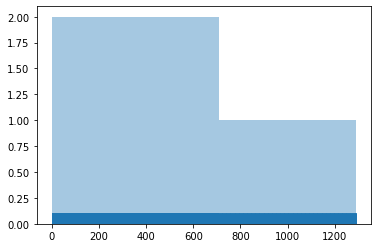

In [18]:
# print(train_images.shape)
# print(train_labels.shape)
# ###Find distribution
# idx_dict = {}
# idx = 0
# idx_arr = []
# for i in range(len(train_labels[:2000])):
#     key = tuple(train_labels[i])
#     if key not in idx_dict.keys():
#         idx_dict[key] = idx
#         idx += 1
#     idx_arr.append(idx_dict[key])        
# u_arr,count = np.unique(idx_arr,return_counts=True)
# # count = sorted(count,reverse=True)
# # print(count[:20])
# nums = len(u_arr)
# print(nums)
# sb.distplot(idx_arr,bins=nums,kde=False,rug=True)

# ###augment all image num to 180
# # num_dict = {}
# # for i in range(len(train_labels)):
# #     key = tuple(train_labels[i])
# #     if key not in num_dict.keys():
# #         num_dict[key] = 1
# #     else:
# #         num_dict[key] += 1

In [8]:
# data_num = np.shape(train_images)[0]
# print(data_num)
# tmp_labels = np.uint8(train_labels).reshape(data_num,-1)
# tmp_images = np.uint8(train_images).reshape(data_num,-1)
# tmp_idx_arr = np.array(idx_arr)
# print(np.shape(tmp_labels))
# print(np.shape(tmp_images))
# print(np.shape(tmp_idx_arr))
# print(np.max(tmp_idx_arr))

In [9]:
# arg_idx = np.argsort(tmp_idx_arr)
# print(len(arg_idx))
# sorted_images = tmp_images[arg_idx]
# sorted_labels = tmp_labels[arg_idx]
# sorted_idx_arr = tmp_idx_arr[arg_idx]

# Get order aug index 

In [10]:
# f_load_imgs = np.load("./0220_balanced_1292x180_imgs.npy")
# f_load_labels = np.load("./0220_balanced_1292x180_labels.npy")

# ###(0,180,360...,1,181,361..)
# order_idx = [] 
# max_len = 232560
# max_num = 180
# walker = 0
# t1 = 0
# while len(order_idx) < max_len:
#     order_idx.append(walker)
#     walker += max_num
#     if walker >= max_len:
#         t1 += 1
#         walker = t1
#     walker %= max_len
# print(len(order_idx))
# print(order_idx[:20])

In [11]:
# f_order_imgs = f_load_imgs[order_idx]
# f_order_labels = f_load_labels[order_idx]
# np.save("./0220_ordered_232560_imgs",f_order_imgs)
# np.save("./0220_ordered_232560_labels",f_order_labels)
f_order_imgs = np.load("./0220_ordered_232560_imgs.npy")
f_order_labels = np.load("./0220_ordered_232560_labels.npy")

(232560, 32332)
(232560, 3)


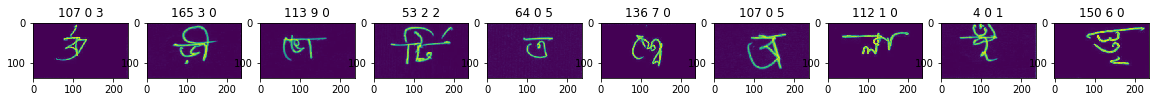

In [22]:
print(np.shape(f_order_imgs))
print(np.shape(f_order_labels))

# offset = 200830
# fig,axes = plt.subplots(1,10,figsize=(20,16))
# for i in range(10):
#     r,v,c = sorted_labels[i+offset]
#     axes[i].set_title("{} {} {}".format(r,v,c))
#     axes[i].imshow(sorted_images[i+offset].reshape(137,236))

# offset = 232560-10
# fig,axes = plt.subplots(1,10,figsize=(20,16))
# for i in range(10):
#     r,v,c = f_load_labels[i+offset]
#     axes[i].set_title("{} {} {}".format(r,v,c))
#     axes[i].imshow(f_load_imgs[i+offset].reshape(137,236))
        
offset = 0
fig,axes = plt.subplots(1,10,figsize=(20,16))
for i in range(10):
    r,v,c = train_labels[i+offset]
    axes[i].set_title("{} {} {}".format(r,v,c))
    axes[i].imshow(train_images[i+offset].reshape(137,236))


In [13]:
# final_len = (1292*180, 127*236)
pre_uid = -1
# tmp_idx2 = [0,0,1,1,1,2,3,4]
# tmp_idx2 = [0,0,0,0,0,0,1,1,1,2,2,2]
# tmp_idx2 = [0,0,0,0,0,0,0,1]

se_dict = {}
for i in range(len(sorted_idx_arr)):
    uid = sorted_idx_arr[i]
    if uid not in se_dict.keys():
        se_dict[uid] = [i,-1]
    if uid != pre_uid and pre_uid in se_dict.keys():
        se_dict[pre_uid][1] = i-1
    pre_uid = uid
se_dict[uid][1] = i

# for key,val in se_dict.items():
#     print(key," ",val)
print(len(se_dict))


1292


In [14]:
balance_trans = transforms.Compose([
        ###Weak1
#         transforms.ColorJitter(0.01, 0.01, 0.01),
        transforms.RandomAffine(degrees=1,translate=(0.05,0.05)),
#         transforms.ToTensor(),
    ])


final_images = []  ###(1292*180, 127*236)
final_labels = []
final_uid = []
max_num = 180
offset = 0
pre_uid = 0
for i in range(len(sorted_idx_arr)):
# for i in range(len(tmp_idx2)):
#     uid = tmp_idx2[i]
    if i%10000 == 0:
        print(i,np.shape(final_images))
        
    uid = sorted_idx_arr[i]
    img = sorted_images[i]
    label = sorted_labels[i]
#     print("current uid",uid)
    
    if offset<max_num and pre_uid == uid:
        final_images.append(img)
        final_labels.append(label)
        final_uid.append(uid)
        offset += 1
#         print("here1 ",final_uid)
        
    elif offset<max_num and pre_uid != uid:
        while offset < max_num:
                ###aug
                start, end = se_dict[pre_uid]                
                rand_idx = np.random.randint(start,end+1)               
                aug_img = sorted_images[rand_idx].reshape(137,236)
#                 fig,axes = plt.subplots(1,1,figsize=(4,4))
#                 axes.imshow(img)
                aug_img = Image.fromarray(aug_img)
                aug_img = balance_trans(aug_img)
#                 fig,axes = plt.subplots(1,1,figsize=(4,4))
#                 axes.imshow(img)
#                 plt.pause(.1)
#                 print(np.max(img),np.shape(img))
#                 input("stop")
                aug_img = np.uint8(aug_img).reshape(-1)
#                 print(np.shape(img),np.shape(final_images[0]))
                final_images.append(aug_img)
                final_labels.append(sorted_labels[start])
                final_uid.append(pre_uid*-1)
                offset += 1
                
        ###Add first element of next class
        final_images.append(img)
        final_labels.append(label)
        final_uid.append(uid)
        offset = 1
#         print("here2 ",final_uid)
        
    elif offset>=max_num and pre_uid == uid:
#         print("here3 ", final_uid)
        None
        
    elif offset>=max_num and pre_uid != uid:
        final_images.append(img)
        final_labels.append(label)
        final_uid.append(uid)
        offset = 1
#         print("here4 ",final_uid)
    else:
        print("wrong")
    
    pre_uid = uid                

while offset < max_num:
    start, end = se_dict[pre_uid]                
    rand_idx = np.random.randint(start,end+1)               
    img = sorted_images[rand_idx].reshape(137,236)
    img = Image.fromarray(img)
    img = balance_trans(img)
    final_images.append(np.uint8(img).reshape(-1))
    final_labels.append(sorted_labels[start])
    final_uid.append(uid)
    offset += 1
        
# print("final ",final_uid)
final_images = np.uint8(final_images)
final_labels = np.uint8(final_labels)
print(np.shape(final_images))
print(np.shape(final_labels))
            

0 (0,)
10000 (11381, 32332)
20000 (22899, 32332)
30000 (34413, 32332)
40000 (45578, 32332)
50000 (57266, 32332)
60000 (68785, 32332)
70000 (80470, 32332)
80000 (92050, 32332)
90000 (103697, 32332)
100000 (115111, 32332)
110000 (126740, 32332)
120000 (138352, 32332)
130000 (149809, 32332)
140000 (161479, 32332)
150000 (173196, 32332)
160000 (184520, 32332)
170000 (196137, 32332)
180000 (207769, 32332)
190000 (219686, 32332)
200000 (231545, 32332)
(232560, 32332)
(232560, 3)


In [15]:
np.save("./0220_balanced_1292x180_imgs",final_images)
np.save("./0220_balanced_1292x180_labels",final_labels)

In [7]:
# tmp_images = np.uint8(np.ones_like(train_images).astype('uint8')*255)
# tmp_images = tmp_images - train_images
# np.save("./train_images_invert_0203.npy", tmp_images)

In [8]:
# print("Shuffle...")
# data_num = np.shape(train_labels)[0]
# tmp_images = np.uint8(train_images).reshape(data_num,-1)
# tmp_labels = np.uint8(train_labels).reshape(data_num,-1)
# print(np.shape(tmp_images))
# print(np.shape(tmp_labels))
# tmp_file = np.concatenate((tmp_labels,tmp_images),axis=1)

# np.random.shuffle(tmp_file)
# np.random.shuffle(tmp_file)
# np.random.shuffle(tmp_file)
# print("tmp_file shape:",np.shape(tmp_file))
# print("Done")

# tmp_images = tmp_file[:,3:].reshape(-1,128,128)
# tmp_labels = tmp_file[:,:3]

# np.save("./128x128_by_lafoss_shuffled.npy", tmp_images)
# np.save("./128x128_by_lafoss_shuffled_label.npy", tmp_labels)

# ###load from npy
# # train_images = np.load("./train_images_shuffle_0202.npy")
# # train_labels = np.load("./train_labels_shuffle_0202.npy")

In [9]:
# from imgaug import augmenters as iaa
# # from imgaug.augmentables.segmaps import SegmentationMapOnImage
# class ImgAugTransform:
#     def __init__(self):
#         self.aug = iaa.Sequential([
# #         iaa.Scale((75, 128)),
# #         iaa.Fliplr(0.5),
# #         iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.6))),
# #         iaa.Sometimes(0.1, iaa.AverageBlur(1.2)),
# #         iaa.Sometimes(1, iaa.Affine(rotate=(-20, 20),order=[0, 1],translate_px={"x":(-2, 2),"y":(-2,2)},mode='symmetric')),
# #         iaa.Sometimes(0.2,iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.25))),
# #         iaa.Sometimes(0.1, iaa.SaltAndPepper(0.05,False)),
#         iaa.Invert(1),
# #         iaa.Add((-5, 5)), # change brightness of images (by -10 to 10 of original value)
# #         iaa.AdditiveGaussianNoise(-1,1)
# #         iaa.Sometimes(0.2,iaa.GammaContrast(2))
            
# #         iaa.AddToHueAndSaturation(from_colorspace="GRAY",value=(-20, 20))  #Hue-> color, saturation -> saido
#     ])
#     def __call__(self, img, mask=None):
#         img = np.array(img)        
#         return self.aug.augment_image(image=img)
# #         return self.aug(image=img, segmentation_maps=label)

# CutMix augmentation

In [10]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]
    return data, targets

def cutmix_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = \
    targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    
#     criterion = nn.CrossEntropyLoss(reduction='mean')
#     criterion = FocalLossMultiLabel(gamma=0.5,weight=torch.tensor([1,1,2],dtype=torch.float32))
    criterion = FocalLossWithOutOneHot(gamma=2)
#     criterion = FocalLossWithOneHot(gamma=2)
#     criterion = dice_loss
    
    
    print("here", preds1.size(), np.shape(targets1))
    l1 = criterion(preds1, targets1)
    print("l1 size:",l1)
    
    
    return lam * criterion(preds1, targets1) + (1 - lam) * \
           criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * \
           criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)


def mixup(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]

    return data, targets


def mixup_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

# GridMask augmentation

In [11]:
# import albumentations
# from albumentations.core.transforms_interface import DualTransform
# from albumentations.augmentations import functional as F
# class GridMask(DualTransform):
#     """GridMask augmentation for image classification and object detection.
    
#     Author: Qishen Ha
#     Email: haqishen@gmail.com
#     2020/01/29

#     Args:
#         num_grid (int): number of grid in a row or column.
#         fill_value (int, float, lisf of int, list of float): value for dropped pixels.
#         rotate ((int, int) or int): range from which a random angle is picked. If rotate is a single int
#             an angle is picked from (-rotate, rotate). Default: (-90, 90)
#         mode (int):
#             0 - cropout a quarter of the square of each grid (left top)
#             1 - reserve a quarter of the square of each grid (left top)
#             2 - cropout 2 quarter of the square of each grid (left top & right bottom)

#     Targets:
#         image, mask

#     Image types:
#         uint8, float32

#     Reference:
#     |  https://arxiv.org/abs/2001.04086
#     |  https://github.com/akuxcw/GridMask
#     """

#     def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
#         super(GridMask, self).__init__(always_apply, p)
#         if isinstance(num_grid, int):
#             num_grid = (num_grid, num_grid)
#         if isinstance(rotate, int):
#             rotate = (-rotate, rotate)
#         self.num_grid = num_grid
#         self.fill_value = fill_value
#         self.rotate = rotate
#         self.mode = mode
#         self.masks = None
#         self.rand_h_max = []
#         self.rand_w_max = []

#     def init_masks(self, height, width):
#         if self.masks is None:
#             self.masks = []
#             n_masks = self.num_grid[1] - self.num_grid[0] + 1
#             for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
#                 grid_h = height / n_g
#                 grid_w = width / n_g
#                 this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
#                 for i in range(n_g + 1):
#                     for j in range(n_g + 1):
#                         this_mask[
#                              int(i * grid_h) : int(i * grid_h + grid_h / 2),
#                              int(j * grid_w) : int(j * grid_w + grid_w / 2)
#                         ] = self.fill_value
#                         if self.mode == 2:
#                             this_mask[
#                                  int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
#                                  int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
#                             ] = self.fill_value
                
#                 if self.mode == 1:
#                     this_mask = 1 - this_mask

#                 self.masks.append(this_mask)
#                 self.rand_h_max.append(grid_h)
#                 self.rand_w_max.append(grid_w)

#     def apply(self, image, mask, rand_h, rand_w, angle, **params):
#         h, w = image.shape[:2]
#         mask = F.rotate(mask, angle) if self.rotate[1] > 0 else mask
#         mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
#         image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
#         return image

#     def get_params_dependent_on_targets(self, params):
#         img = params['image']
#         height, width = img.shape[:2]
#         self.init_masks(height, width)

#         mid = np.random.randint(len(self.masks))
#         mask = self.masks[mid]
#         rand_h = np.random.randint(self.rand_h_max[mid])
#         rand_w = np.random.randint(self.rand_w_max[mid])
#         angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

#         return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

#     @property
#     def targets_as_params(self):
#         return ['image']

#     def get_transform_init_args_names(self):
#         return ('num_grid', 'fill_value', 'rotate', 'mode')

# Trans and Dataset definition

In [203]:
IMAGE_SIZE = (128,128)
NO_EXTRA_AUG = True
import random
trans = transforms.Compose([
        ###Weak1
        transforms.ColorJitter(0.01, 0.01, 0.01),
        transforms.RandomAffine(degrees=3,translate=(0.05,0.05),scale=[0.95,1.05],shear=3),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.0530355],std=[[0.15949783]]), #train_images 224x224 vr 0        
        transforms.Normalize(mean=[0.05302268],std=[0.15688393]), #train_images 128x128 vr 0
    ])

trans_none = transforms.Compose([
        transforms.Resize(IMAGE_SIZE), #For resnet
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.05302268],std=[0.15688393]) #train_images 128x128 vr 0
        # transforms.Normalize(mean=[0.0530355],std=[[0.15949783]]) #train_images 224x224 vr 0        
])

trans_post = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(0.01, 0.01, 0.01),
        transforms.RandomAffine(degrees=3,translate=(0.05,0.05),scale=[0.5,1.5],shear=3),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.0530355],std=[[0.15949783]]), #train_images 224x224 vr 0        
        transforms.Normalize(mean=[0.05302268],std=[0.15688393]), #train_images 128x128 vr 0
])

trans_val = transforms.Compose([
        transforms.Resize(IMAGE_SIZE), #For resnet
        transforms.ToTensor(),  #Take Image as input and convert to tensor with value from 0 to1  
        # transforms.Normalize(mean=[0.05302268],std=[0.15688393]) #train_images 128x128 vr 0
        # transforms.Normalize(mean=[0.0530355],std=[[0.15949783]]) #train_images 224x224 vr 0        
    ])


def get_augmented_img(img):
#     output_img = func_Erosion(img)
#     output_img = func_Dilation(img)
#     output_img = func_opening(img)
#     output_img = func_closing(img)
    output_img = func_hybrid(img)
    return output_img

def func_Erosion(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 5, 2)))
    img = cv2.erode(img, kernel, iterations=1)
    return img

def func_Dilation(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 5, 2)))
    img = cv2.dilate(img, kernel, iterations=1)
    return img

def get_random_kernel():
    structure = np.random.choice([cv2.MORPH_RECT, cv2.MORPH_ELLIPSE, cv2.MORPH_CROSS])
    kernel = cv2.getStructuringElement(structure, tuple(np.random.randint(1, 5, 2)))
    return kernel

def func_opening(img):
    img = cv2.erode(img, get_random_kernel(), iterations=1)
    img = cv2.dilate(img, get_random_kernel(), iterations=1)
    return img

def func_closing(img):
    img = cv2.dilate(img, get_random_kernel(), iterations=1)
    img = cv2.erode(img, get_random_kernel(), iterations=1)
    return img

def func_hybrid(img):
    rand_tag = np.random.random()
    if rand_tag < 0.25:
        img = func_Erosion(img)
    elif rand_tag < 0.5:
        img = func_Dilation(img)
    elif rand_tag < 0.75:
        img = func_opening(img)
    else:
        img = func_closing(img)        
    return img


class BengaliDataset(Dataset):
    def __init__(self,data_len=None, is_validate=False,validate_rate=None,indices=None):
        self.is_validate = is_validate
        self.data = train_images
        self.label = train_labels
        if data_len == None:
            data_len = len(self.data)
        
        self.indices = indices
        if self.is_validate:
            self.len = int(data_len*validate_rate)
            self.offset = int(data_len*(1-validate_rate))
            self.transform = trans_val
        else:
            self.len = int(data_len*(1-validate_rate))
            self.offset = 0
            if NO_EXTRA_AUG:
                self.transform = trans_none
            else:
                self.transform = trans

    def set_transform(self,tag):
        self.transform = trans if tag else trans_none

    def __getitem__(self, idx):
        random.seed(np.random.randint(1000000))

        idx += self.offset
        idx = self.indices[idx]
        img = np.uint8(self.data[idx]) #(137,236), value: 0~255
        labels = self.label[idx] #(num,3) grapheme_root, vowel_diacritic, constant_diacritic
        img = Image.fromarray(img)
        img = self.transform(img)     #value: 0~1, shape:(1,137,236)
        label = torch.as_tensor(labels, dtype=torch.uint8)    #value: 0~9, shape(3)
        # aug_tag = False if np.random.random() < CUT_MIX_RATE else True

        return img, labels

    def __len__(self):
        return self.len   

# Show augmented result

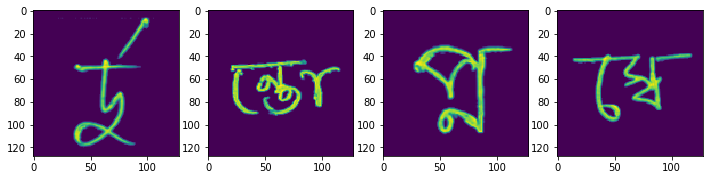

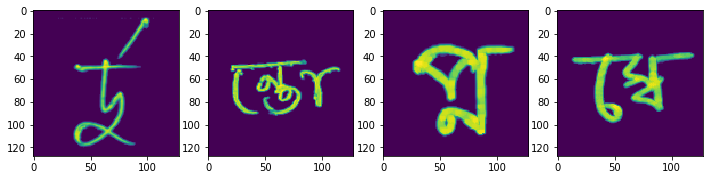

NameError: name 'stop' is not defined

In [214]:
indices_len = len(train_images)
ind = np.arange(indices_len)
tmp = BengaliDataset(data_len=None,is_validate=False, validate_rate=0.9,indices=ind)
tmp_loader = DataLoader(tmp, batch_size=4, shuffle=False, num_workers=1)

for i,data in enumerate(tmp_loader):
    img, labels = data
    img, labels = img.to(device), labels.to(device).long()
    
    fig, axes = plt.subplots(1,4,figsize=(12,6))
    axes = axes.flatten()
    for j in range(4):
        axes[j].imshow(img[j][0].cpu().numpy())
    plt.pause(.1)
    
    for j in range(img.size(0)):
#         print("img size:",img.size())
        tmp_img = np.uint8(img[j][0].cpu().numpy()*255)
        tmp_img = get_augmented_img(tmp_img)
#         print("tmp img size:",np.shape(tmp_img))
        img[j] = torch.from_numpy(tmp_img/255)

#     print(img.size())
    fig, axes = plt.subplots(1,4,figsize=(12,6))
    axes = axes.flatten()
    for j in range(4):
        axes[j].imshow(img[j][0].cpu().numpy())
    plt.pause(.1)
    
    stop
    
#     print("labels:",train_labels[i])
#     print(img.size())
#     print(labels.size(),labels.type())
#     print(np.shape(img[:,None,:,:]))
    
    ###Cutmix test
#     if np.random.random()<0.5:
#         aug_img, targets = cutmix(img, labels[:,0],labels[:,1],labels[:,2],alpha=1)
#         pred_root, pred_vowel, pred_constant = model(aug_img)
#         loss = cutmix_criterion(pred_root,pred_vowel,pred_constant,targets)
#         print(loss.item())
        
#     print(aug_img.size(),aug_img.type())
#     print(len(targets),targets[0].size(),targets[0].type())
    
#     img = torch.as_tensor(img, dtype=torch.uint8)
#     labels = torch.as_tensor(labels, dtype=torch.uint8)
#     print(type(img))
#     print(type(labels))
#     print(label)

# Get kfold dataset loader

In [ ]:
def get_kfold_dataset_loader(k=5,val_rate=0.1,indices_len=None, batch_size=None,num_workers=None):
    ###Return [list of train dataset_loader, list of val dataset_loader]
    train_loader_list = []
    val_loader_list = []
    indices = np.arange(indices_len)
    val_len = indices_len//k
    idx = 0
    
    for i in range(k):
#         np.random.shuffle(indices)  #Random cross validation
        ind = np.concatenate([indices[:idx],indices[idx+val_len:],indices[idx:idx+val_len]])
        idx += val_len
        
        train_dataset = BengaliDataset(data_len=None,is_validate=False, validate_rate=val_rate,indices=ind)
        val_dataset = BengaliDataset(data_len=None,is_validate=True, validate_rate=val_rate, indices=ind)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        
        train_loader_list.append(train_loader)
        val_loader_list.append(val_loader)
        
    return train_loader_list, val_loader_list


# Get models

In [ ]:
def get_model():
#     model = SE_Net3(in_channels=1)
#     model = EffNet(in_channels=1)
    model = get_resnext_model(model_type="50", pretrained="False")
    if device == "cuda":
        model.cuda()
    return model


# Get dataset distribution

In [ ]:
# train distribution: mean=[0.08229437],std=[0.23876116]
# dig augmented distribution: mean=[0.09549136],std=[0.24336776]
# train large distribution: mean=[0.08889286],std=[0.24106438]

def get_dataset_mean_std(dataloader):
    print("Calculate distribution:")
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data in dataloader:
        img = data[0].to(device)
        batch_samples = img.size(0)
        img = img.contiguous().view(batch_samples, img.size(1), -1)
        mean += img.mean(2).sum(0)
        std += img.std(2).sum(0)
        nb_samples += batch_samples
        if nb_samples%5120 == 0:
            print("Finished:", nb_samples)
            
    print("num of samples:",nb_samples)
    mean /= nb_samples
    std /= nb_samples
#     print("Average mean:",mean)
#     print("Average std:", std)
    return mean.cpu().numpy(), std.cpu().numpy()

# Get train and val loaders

In [ ]:
batch_size = 16
num_workers = 12
k = 1
indices_len = 200840
vr = 0.01

# indices_len = 10240  ################Temp Revised Caution##############
# indices_len = 120000

###Single dataset
# indices = np.arange(indices_len)
# train_dataset = BengaliDataset(data_len=None,is_validate=False,validate_rate=vr,indices=indices)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
# mean, std = get_dataset_mean_std(train_loader)
# print("train distribution: mean={},std={}".format(mean, std))

# indices = np.arange(10240)
# dig_val_dataset = DigValDataset(data_len=None,indices=indices)
# dig_val_loader = DataLoader(dig_val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
# mean, std = get_dataset_mean_std(dig_val_loader)
# print("validate distribution:",mean, std)

# test_dataset = TestDataset(data_len=None)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
# mean, std = get_dataset_mean_std(test_loader)
# print("test distribution:",mean, std)

###K-fold dataset
# vr = (indices_len//k)/indices_len
print("validation rate:",vr)
train_loaders, val_loaders = get_kfold_dataset_loader(k, vr, indices_len, batch_size, num_workers)

# Train digit classifier

In [ ]:
if __name__ == "__main__":
    epochs = 300
    ensemble_models = []
    lr = 1e-3
    val_period = 1000
    train_period = 100
    criterion = torch.nn.CrossEntropyLoss()
    cutmix_tag = False
#     criterion_b = torch.nn.BCEWithLogitsLoss()
    while True:
        print("Fold:",len(train_loaders))

        for fold in range(0,len(train_loaders)):
            train_loader = train_loaders[fold]
            val_loader = val_loaders[fold]
            model = get_model()
            max_acc = 0
            min_loss = 10000
            best_model_dict = None
            data_num = 0
            loss_avg = 0
            loss_root_avg = 0
            loss_vowel_avg = 0
            loss_constant_avg = 0

#             optimizer = torch.optim.Adamax(model.parameters(),lr=0.002,weight_decay=0)
    #         optimizer = torch.optim.SGD(model.parameters(),lr=lr)
#             optimizer = torch.optim.RMSprop(model.parameters(),lr=lr)
            optimizer = torch.optim.Adam(model.parameters(),lr=lr,betas=(0.9,0.99))
    #         optimizer = torch.optim.Adagrad(model.parameters(),lr=lr)
    #         optimizer = adabound.AdaBound(model.parameters(), lr=lr, final_lr=0.01,amsbound=True)
    #         optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4, nesterov=True)
    #         lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=period,T_mult=1,eta_min=1e-5) #original 
            lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=30,factor=0.1)

            for ep in range(0,epochs+1):
                model.train()
                for idx, data in enumerate(train_loader):
#                     if idx%10 == 0:
#                         print(idx)
                    img, target = data
                    img, target = img.to(device), target.to(device,dtype=torch.long)
            
                    cutmix_tag = True if np.random.random()<1 else False
                
                    if cutmix_tag == True:
                        img, targets = cutmix(img, target[:,0],target[:,1],target[:,2],alpha=np.random.uniform(0.8,1))
            
                    pred_root, pred_vowel, pred_constant = model.new_forward(img)
#                     print(np.shape(img),np.shape(target)) #Tensor(batch,1,75,128)
#                     print(np.max(img.cpu().numpy()),np.min(img.cpu().numpy())) #1.0 0.0
                    
#                     print(pred_root.size())   #(batch,168)
#                     print(pred_vowel.size())   #(batch,11)
#                     print(pred_constant.size())   #(batch,7)
#                     print(target.size()) #(batch,3)
                    
                    ##Cutmix test
                    if cutmix_tag == True:
                        loss = cutmix_criterion(pred_root,pred_vowel,pred_constant,targets)
                        print("loss",loss)
#                         print(loss.item())                        
                    else:
                        ###Input shape: input:(batch_num,1), target:(batch_num,a int 0 or 1) for CSE LOSS, target:(batch_num,1) for BCE loss
        #                 loss_b = criterion_b(pred_b,target_b) 
                        ###Input shape: input:(batch_num,10), target:(batch_num,a int between 0~10)
    #                     print(target[:,0].shape)
                        loss_root = criterion(pred_root,target[:,0])
                        loss_vowel = criterion(pred_vowel,target[:,1])
                        loss_constant = criterion(pred_constant,target[:,2])
                        loss = loss_root + loss_vowel + loss_constant
                        loss_root_avg += loss_root.item()
                        loss_vowel_avg += loss_vowel.item()
                        loss_constant_avg += loss_constant.item()
                        loss_avg += loss.item()

                    data_num += img.size(0)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    ###Evaluate Train Loss 
#                     if idx%train_period == 0:
#                         loss_avg /= data_num
#                         loss_root_avg /= data_num
#                         loss_vowel_avg /= data_num
#                         loss_constant_avg /= data_num
#                         print("Train Ep:{},loss:{:.3f},rl:{:.3f},vl{:.3f},cl{:.3f},lr:{}".
#                               format(ep, loss_avg,loss_root_avg,loss_vowel_avg,loss_constant_avg,optimizer.param_groups[0]['lr']))
#                         loss_avg = loss_root_avg = loss_vowel_avg = loss_constant_avg = 0
#                         data_num = 0

                    ###Cosine annealing
        #             lr_scheduler.step()                    

                    ###Validation
                    if idx!=0 and idx%val_period == 0:
                        model.eval()
                        acc_root = 0
                        acc_vowel = 0
                        acc_constant = 0
                        acc = 0
                        val_loss_root = 0
                        val_loss_vowel = 0
                        val_loss_constant = 0
                        val_loss = 0
                        data_num  = 0
                        with torch.no_grad():
                            for idx, data in enumerate(val_loader):
                                img, target = data
                                img, target = img.to(device), target.to(device,dtype=torch.long)
                                tmp = model(img)
                                pred_root, pred_vowel, pred_constant = model.new_forward(img)
                                
                                val_loss_root += criterion(pred_root, target[:,0]).item()
                                val_loss_vowel += criterion(pred_vowel, target[:,1]).item()
                                val_loss_constant += criterion(pred_constant, target[:,2]).item()

                                # print(pred) 
                                _,pred_class_root = torch.max(pred_root.data, 1)
                                _,pred_class_vowel = torch.max(pred_vowel.data, 1)
                                _,pred_class_constant = torch.max(pred_constant.data, 1)

            #                   print(pred_class)
                                acc_root += (pred_class_root == target[:,0]).sum().item()
                                acc_vowel += (pred_class_vowel == target[:,1]).sum().item()
                                acc_constant += (pred_class_constant == target[:,2]).sum().item()

                                data_num += img.size(0)

                        acc_root /= data_num
                        acc_vowel /= data_num
                        acc_constant /= data_num
                        val_loss_root /= data_num
                        val_loss_vowel /= data_num
                        val_loss_constant /= data_num

                        acc = (2*acc_root + acc_vowel + acc_constant)/4
                        val_loss = (2*val_loss_root + val_loss_vowel + val_loss_constant)/4

                        ###Plateau
#                         lr_scheduler.step(val_loss)               
                        lr_scheduler.step(-1*acc)                  

                        if acc >= max_acc:
                            max_acc = acc
                            min_loss = val_loss
                            best_model_dict = model.state_dict()                    

                            if max_acc>0.97:
                                torch.save(best_model_dict, "./Bengali_saved_model/adam_eff_Fold{}_acc{:.4f}".format(fold,max_acc*1e2))
                        
                        torch.save(best_model_dict, "./Bengali_saved_model/adam_eff_Fold{}_current".format(fold))
                        
        #                 if val_loss <= min_loss:
        #                     max_acc = acc
        #                     min_loss = val_loss
        #                     best_model_dict = model.state_dict()

                        print("Val Ep{},Loss:{:.6f},rl{:.4f},vl{:.4f},cl{:.4f},Acc:{:.4f}%,ra:{:.4f}%,va:{:.4f}%,ca:{:.4f}%,lr:{}"
                              .format(ep,val_loss,val_loss_root,val_loss_vowel,val_loss_constant,acc*100,acc_root*100,acc_vowel*100,acc_constant*100,optimizer.param_groups[0]['lr']))

                if optimizer.param_groups[0]['lr'] < 1e-5:
                    break         
                    
            ###K-Fold ensemble: Saved k best model for k dataloader
            print("===================Best Fold:{} Saved Loss:{} Acc:{}==================".format(fold,min_loss,max_acc))
            torch.save(best_model_dict, "./Bengali_saved_model/adam_eff_Fold{}_loss{:.4f}_acc{:.3f}".format(fold,min_loss*1e3,max_acc*1e2))
            print("======================================================")

            del model
            torch.cuda.empty_cache()


In [ ]:
print(max_acc)
torch.save(best_model_dict, "./Bengali_saved_model/Fold{}_acc{}".format(fold,max_acc))

In [ ]:

print(np.where(label!=result)[0])
print(np.where(label!=result1)[0])

In [ ]:
self.data = global_dataimport torch
import numpy as np

t1 = torch.Tensor([[1,2,3,4],[4,3,2,1],[1,5,3,3]])  #(3,4)
t1 = t1.unsqueeze(2)

t_list = torch.Tensor([])

for i in range(3):
    t_list = torch.cat((t_list,t1),dim=2)

print(t_list.size())
print(t_list)
t_list = torch.mean(t_list,dim=2)
print(t_list.size())
print(t_list)


# n1 = t1.cpu().numpy()

# n1, count = np.unique(n1,return_counts=True,axis=0)
# print(count)
# n1 = np.argmax(count)

